In [1]:
import torch.nn as nn 
import torchvision
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib 
from tqdm import tqdm 
import torch.optim as optim
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from glob import glob 
import os 

In [2]:
class Res_Net(nn.Module):
    def __init__(self,classes):
        super().__init__()
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, len(classes))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [3]:
class BP_Eye_Dataset(Dataset):
    def __init__(self, image_paths, classes, my_transforms):
        self.image_paths = image_paths
        self.classes = classes
        self.my_transforms = my_transforms

        self.idx_to_class = {i:j for i, j in enumerate(self.classes)}
        self.class_to_idx = {value:key for key,value in self.idx_to_class.items()}
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx] 
        label = image_filepath.split('/')[-2]

        image = torchvision.io.read_image(image_filepath)
        
        image = self.my_transforms(image)
        label_final = self.class_to_idx[label]

        return image, label_final

In [4]:
num_epochs = 1
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_path = '/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/train/'
val_path = '/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/validation/'
test_path = '/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/test/'

In [5]:
train_data_paths = glob(train_path + "*/*.jpg")
val_data_paths = glob(val_path + "*/*.jpg")
test_data_paths = glob(test_path + "*/*.jpg")

In [6]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize((256,256))
])

In [7]:
train_dataset = BP_Eye_Dataset(train_data_paths, classes = ["NRG", "RG"], my_transforms=my_transforms)

In [10]:
train_dataset[:20]

AttributeError: 'list' object has no attribute 'split'

In [9]:
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=my_transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform=my_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=my_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

NameError: name 'my_transform' is not defined

In [ ]:
model = Res_Net(classes=classes)
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def get_needed_metrics(labels, predicted): 
    assert isinstance(labels, list)
    assert isinstance(predicted, list)
    
    accuracy = accuracy_score(labels, predicted)
    precision = precision_score(labels, predicted, zero_division=0.0)
    recall = recall_score(labels, predicted, zero_division=0.0)
    f1 = f1_score(labels, predicted, zero_division=0.0)
    
    return accuracy, precision, recall, f1

In [ ]:
for epoch in range(num_epochs):
        model.train()
        acc_train_epoch, precision_train_epoch, recall_train_epoch, f1_train_epoch  = [], [], [], []
        for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch}/{num_epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = nn.Sigmoid()(model(inputs))     
            
            train_loss = loss_func(outputs, labels)
            train_loss.backward()
            optimizer.step()
        
            _, predicted_train = torch.max(outputs, 1)
            

            acc_batch_train, precision_batch_train, recall_batch_train, f1_batch_train = get_needed_metrics(labels.cpu().detach().tolist(), predicted_train.cpu().detach().tolist())
        
            acc_train_epoch.append(acc_batch_train)
            precision_train_epoch.append(precision_batch_train)
            recall_train_epoch.append(recall_batch_train)
            f1_train_epoch.append(f1_batch_train)
        
        # Validating the model
        model.eval()
        acc_val_epoch, precision_val_epoch, recall_val_epoch, f1_val_epoch  = [], [], [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Testing {epoch}/{num_epochs}', unit='batch'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = nn.Sigmoid()(model(inputs))     
                val_loss = loss_func(outputs, labels)
                _, predicted_val = torch.max(outputs, 1)

                acc_batch_val, precision_batch_val, recall_batch_val, f1_batch_val = get_needed_metrics(labels.cpu().detach().tolist(), predicted_val.cpu().detach().tolist())
                
                acc_val_epoch.append(acc_batch_val)
                precision_val_epoch.append(precision_batch_val)
                recall_val_epoch.append(recall_batch_val)
                f1_val_epoch.append(f1_batch_val)

In [ ]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
}
torch.save(checkpoint, '/home/shirshak/BPEye_Project_2024/zzz_tests/checkpoint.pth')

# FOR TESTING PURPOSES ONLY

In [ ]:
import torch.nn as nn 
import torchvision
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib 
from tqdm import tqdm 
import torch.optim as optim
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
test_path = '/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/test/'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # convert 0-255 to 0-1 and from np to tensors
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [ ]:
class Res_Net(nn.Module):
    def __init__(self,classes):
        super().__init__()
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, len(classes))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # print(self.model.fc.in_features)
        return self.model(x)

In [ ]:
def get_needed_metrics(labels, predicted): 
    assert isinstance(labels, list)
    assert isinstance(predicted, list)
    
    accuracy = accuracy_score(labels, predicted)
    precision = precision_score(labels, predicted, zero_division=0.0)
    recall = recall_score(labels, predicted, zero_division=0.0)
    f1 = f1_score(labels, predicted, zero_division=0.0)
    
    return accuracy, precision, recall, f1

In [ ]:
root=pathlib.Path(test_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
loaded_model = Res_Net(classes=classes)
checkpoint = torch.load('/home/shirshak/BPEye_Project_2024/zzz_tests/checkpoint.pth')
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-4)
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loaded_model.eval()
acc_test_epoch, precision_test_epoch, recall_test_epoch, f1_test_epoch  = [], [], [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f'Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = nn.Sigmoid()(loaded_model(inputs))     
        val_loss = loss_func(outputs, labels)
        _, predicted_test = torch.max(outputs, 1)

        acc_batch_test, precision_batch_test, recall_batch_test, f1_batch_test = get_needed_metrics(labels.cpu().detach().tolist(), predicted_test.cpu().detach().tolist())
        
        acc_test_epoch.append(acc_batch_test)
        precision_test_epoch.append(precision_batch_test)
        recall_test_epoch.append(recall_batch_test)
        f1_test_epoch.append(f1_batch_test)

In [ ]:
torch.tensor(acc_test_epoch).mean(), torch.tensor(precision_test_epoch).mean(), torch.tensor(recall_test_epoch).mean(), torch.tensor(f1_test_epoch).mean()

In [ ]:
import os
import torchvision
from torchvision.transforms import transforms

In [ ]:
transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), # convert 0-255 to 0-1 and from np to tensors
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            transforms.Resize((256,256))
        ])


class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        return (img, label, path)    

In [ ]:
root_dir = "/mnt/Enterprise2/shirshak/GLAUCOMA_DATASET_EYEPACS_AIROGS_ZENODO/preprocessed_separated_train_test_val/"

In [ ]:
data_train = ImageFolderWithPaths(root=os.path.join(root_dir, "train"), transform=transforms)
data_val = ImageFolderWithPaths(root=os.path.join(root_dir, "val"), transform=transforms)
data_test = ImageFolderWithPaths(root=os.path.join(root_dir, "test"), transform=transforms)

#TODO CHANGE THIS WHEN DOING FULL PIPELINE
data_train = data_train[:20]
data_val = data_val[:20]
data_test = data_test[:20]

In [ ]:
data_train[0]

# Just other zzz tests 

In [1]:
import torch.nn as nn 
import torch 

In [10]:
my_input = torch.tensor([[1.6808e-10, 1.0000e+00],
        [1.0000e+00, 1.6941e-12]])
target = torch.tensor([1, 0])

In [58]:
my_input = torch.tensor([[1.6808e-10, 1.0000e+00],
        [1.0000e+00, 1.6941e-12]])

nn.Softmax()(my_input)


/mnt/Enterprise2/shirshak/miniconda3/envs/BPEye_Project_2024/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.2689, 0.7311],
        [0.7311, 0.2689]])

In [57]:
print(my_input.shape)
print(target.shape)
torch.nn.CrossEntropyLoss()(my_input, target)

torch.Size([2, 2])
torch.Size([2])


tensor(0.)

In [56]:
my_input = torch.tensor([[-100, 100],
        [100, -100]], dtype = torch.float32)
target = torch.tensor([1 ,0])

In [46]:
my_input

tensor([[1.6808e-10, 1.0000e+00],
        [1.0000e+00, 1.6941e-12]])

In [44]:
torch.gather(my_input, 1, target.view(-1, 1)).squeeze()

tensor([1., 1.])

In [30]:
my_input2 = torch.gather(my_input, 1, target.view(-1, 1)).squeeze()
my_input2

tensor([1., 1.])

In [ ]:
my_input2 = torch.gather(my_input, 1, target.view(-1, 1)).squeeze()
my_input2

tensor([1., 1.])

In [32]:
my_input2

tensor([1., 1.])

In [31]:
target.float()

tensor([1., 0.])

In [38]:
my_input = torch.tensor([0, 1]).float()

In [40]:
torch.nn.BCELoss()(my_input,my_input)

tensor(0.)

# Data Augmentation Test 

In [25]:
import torch.nn as nn 
import torchvision
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib 
from tqdm import tqdm 
import torch.optim as optim
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from glob import glob 
import os 
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
test_images = sorted(glob('/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/test/RG/*.jpg'))

In [33]:
test_images[0]

'/mnt/Enterprise2/shirshak/Glaucoma_Dataset_eyepacs_airogs_lightv2/eyepac-light-v2-512-jpg/test/RG/EyePACS-TRAIN-RG-2886.jpg'

In [34]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # transforms.Resize((256,256))
])

In [45]:
image = torchvision.io.read_image(test_images[12])
image.shape

torch.Size([3, 512, 512])

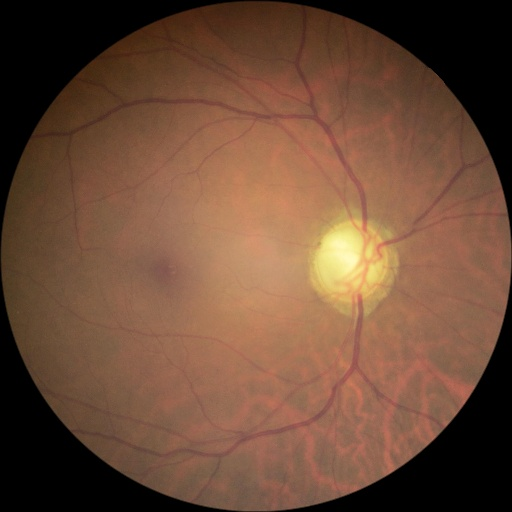

In [38]:
my_img = transforms.ToPILImage()(image)
my_img

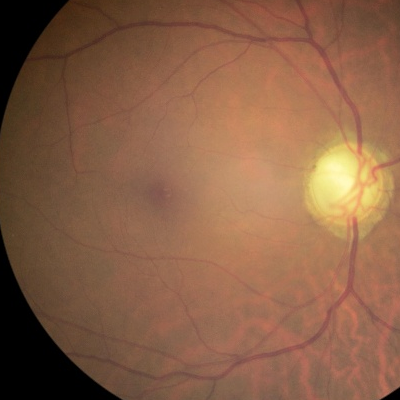

In [47]:
my_transform = transforms.Compose([
    transforms.RandomCrop(size = (400, 400)),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img

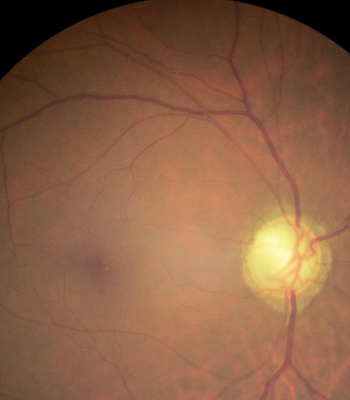

In [52]:
my_transform = transforms.Compose([
    transforms.RandomCrop(size = (400, 350)),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img

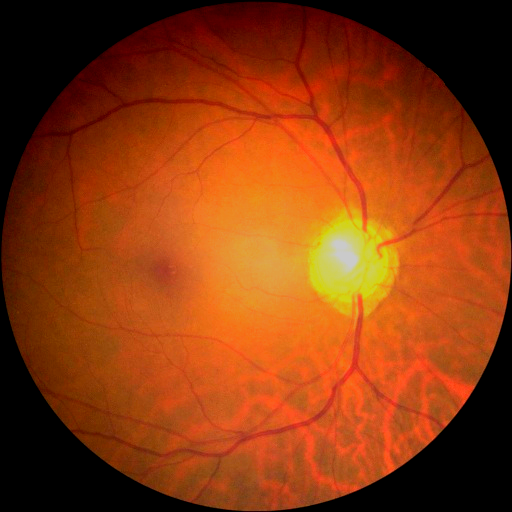

In [62]:
my_transform = transforms.Compose([
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=(3),saturation=(0.8,2.1),hue=(-0.01,0.01)),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img

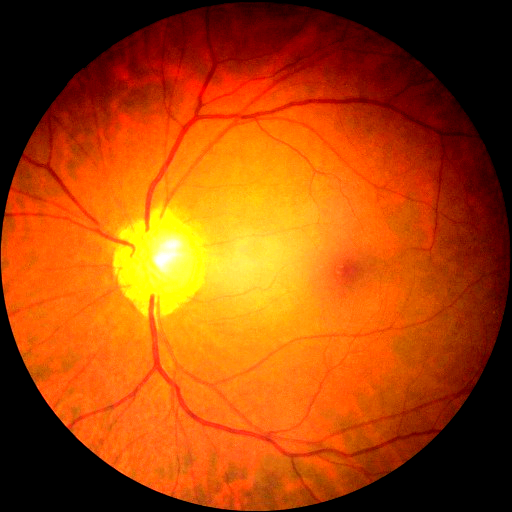

In [66]:
my_transform = transforms.Compose([
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=(3),saturation=(0.8,2.1),hue=(-0.01,0.01)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img

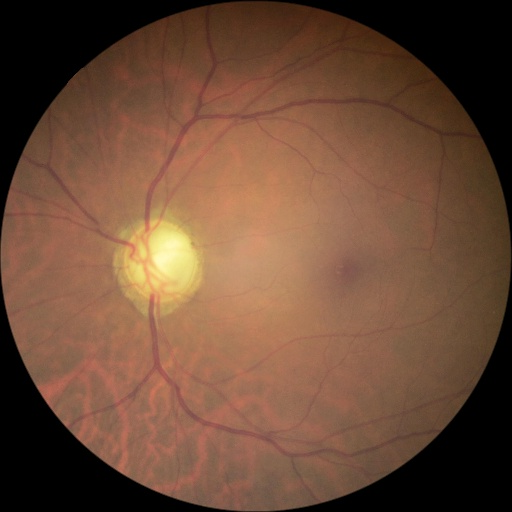

In [67]:
my_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img

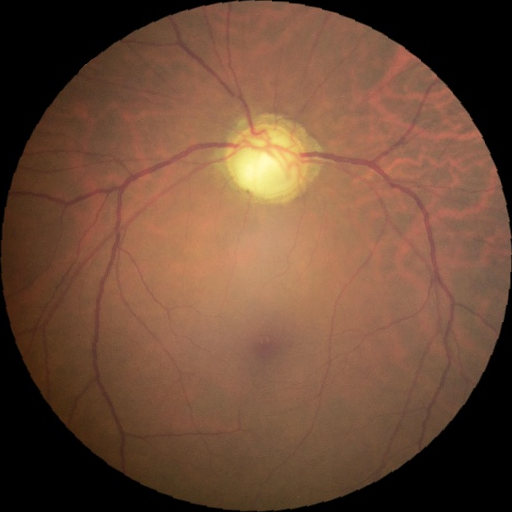

In [73]:

my_transform = transforms.Compose([
    transforms.RandomRotation(90), 
    # transforms.RandomHorizontalFlip(p=1),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img


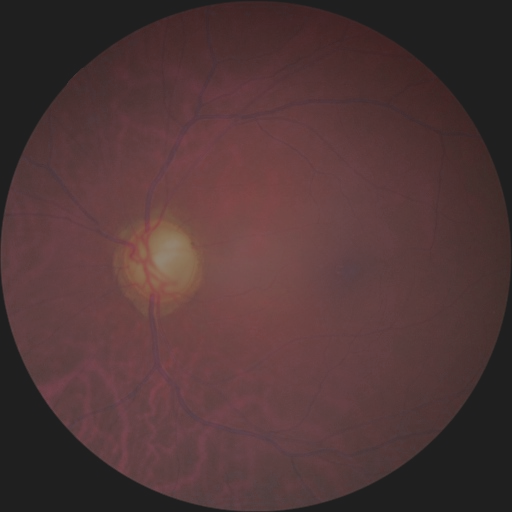

In [101]:
my_transform = transforms.Compose([
    transforms.ColorJitter(brightness=(2.5),contrast=(1.5),saturation=(0.8),hue=(-0.1,0.1)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToPILImage()
])
my_img = my_transform(image)
my_img
